# SGD 경사하강법을 이용한 MF 행렬 작성

### MF 방식의 원리

<img src="https://i.imgur.com/90NB5Y1.png" width=400 />

$$R \approx P\times Q^T=\hat{R}$$

R: Rating matrix, P: User latent matrix, Q: Item latent matrix, k: latent factor(잠재 요인), $\hat{R}$: 예측값

- R 행렬의 각 element는 해당 사용자 아이템에 대한 평점. 이 행렬은 사용자가 실제로 평가한 아이템에 대한 평점만을 가지고 있으므로 많은 원소가 null 로 채워진 sparse matrix 이다.
- R 행렬을 사용자 행렬 (P)와 아이템 행렬(Q)로 쪼개어 분석하는 방법이  MF  
- $\hat{R}$이 최대한 R에 가까운 값을 가지도록 하는 P와 Q를 구하면 그 것이 바로 추천을 위한 model이 된다.

$$\hat{r_{ij}}=b+bu_i + bd_j + \sum_{k=1}^k{p_{ik}q_{kj}}$$

$\hat{r_{ij}}$: 사용자 i 의 아이템 j 에  대한 예측값,  
b: 전체 평균. 일단 데이터가 주어지면 하나로 정해지는 값   
$bu_i$: 전체 평균을 제거한 후 사용자 i의 평가 경향(사용자 i의 평균과 전체 평균의 차이)     
$bd_j$: 전체 평균을 제거한 후 아이템 j의 평가 경향(아이템 j의 평균과 전체 평균의 차이)   
$p_{ik}$: 행렬 P의 i 번째 사용자 vector    
$q_{kj}$: 행렬 Q의 column j 번째 item vector

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 평점 데이터의 컬럼 이름을 정의
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# 평점 데이터를 읽어옴
ratings = pd.read_csv('data/u.rating', sep='\t', names=r_cols, encoding='latin-1')

ratings = ratings[['user_id', 'movie_id', 'rating']]

ratings_train, ratings_test = train_test_split(ratings, test_size=0.25, random_state=0)
ratings_train.shape, ratings_test.shape

((75000, 3), (25000, 3))

In [2]:
# 사용자-아이템 평점 매트릭스를 생성
# fillna(0): 평점이 없는 경우 0으로 채워서 행렬 완성
R_temp_train = ratings_train.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

print(R_temp_train.shape)
R_temp_train.head()

(943, 1628)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1668,1669,1672,1673,1674,1676,1677,1678,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,0.0,5.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#첫 번째 배열 - 행 인덱스를 나타냅니다.
#두 번째 배열 - 열 인덱스를 나타냅니다.
R_temp_train.values.nonzero()

(array([  0,   0,   0, ..., 942, 942, 942], dtype=int64),
 array([   0,    1,    2, ..., 1181, 1221, 1322], dtype=int64))

In [4]:
# 평점 행렬 R_temp_train에서 0이 아닌 값을 모두 가져옴
R_temp_train.values[R_temp_train.values.nonzero()]

array([5., 3., 4., ..., 3., 3., 3.])

In [57]:
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations):
        # 평점 행렬 초기화
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)  # 사용자 수와 아이템 수 계산
        self.K = K  # 잠재 요인 개수
        self.alpha = alpha  # 학습률
        self.beta = beta  # 정규화 파라미터
        self.iterations = iterations  # 학습 반복 횟수

    def rmse(self):
        # RMSE(평균 제곱근 오차)를 계산하는 함수
        xs, ys = self.R.nonzero()  # 평점이 매겨진 위치의 인덱스
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)  # 예측 값 계산
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)  # 실제 값과의 차이(오차) 계산
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors ** 2))  # RMSE 반환

    def get_prediction(self, i, j):
        # 특정 사용자와 아이템에 대한 예측 평점 계산
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j,:].T)
        return prediction

    # 학습을 통해 P, Q 행렬과 편향을 최적화하는 함수
    def train(self):
        #초기 random 값의 표준편차를 1/K로 작게 설정하면 학습이 안정적으로 진행
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))  # 사용자 잠재 요인 행렬 초기화 
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))  # 아이템 잠재 요인 행렬 초기화 

        self.b_u = np.zeros(self.num_users)  # 사용자 편향 초기화
        self.b_d = np.zeros(self.num_items)  # 아이템 편향 초기화
        self.b = np.mean(self.R[self.R.nonzero()])  # 전체 편향 초기화 (평점의 평균 값)

        rows, columns = self.R.nonzero()  # 평점이 있는 위치
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]  # 학습 샘플 생성

        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)  # 샘플 순서 랜덤화
            self.sgd()  # 확률적 경사 하강법으로 학습
            rmse = self.rmse()  # 현재 RMSE 계산
            training_process.append((i+1, rmse))  # 학습 과정 저장
            if (i+1) % 10 == 0:
                print(f"Iteration: {i+1}, Train RMSE = {rmse:.4f}")
        return training_process

    def sgd(self):
        # 확률적 경사 하강법(Stochastic Gradient Descent)으로 P, Q, 편향 업데이트
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)  # 현재 예측 값
            e = (r - prediction)  # 실제 값과 예측 값의 오차

            # 사용자 및 아이템 편향 업데이트
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            # 사용자 및 아이템 잠재 요인 행렬 업데이트
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])

    def predict(self, test_data):
        # 테스트 데이터에 대해 예측 평점 계산
        predictions = []
        for _, row in test_data.iterrows():
            user, item = int(row['user_id']), int(row['movie_id'])
            if user < self.num_users and item < self.num_items:  # 유효한 인덱스인지 확인
                prediction = self.get_prediction(user, item)
                predictions.append(prediction)
            else:
                predictions.append(np.nan)  # 유효하지 않은 인덱스는 NaN으로 처리
        return np.array(predictions)

In [58]:
mf = MF(R_temp_train, K=30, alpha=0.005, beta=0.3, iterations=100)

In [59]:
train_process = mf.train()

Iteration: 10, Train RMSE = 0.9360
Iteration: 20, Train RMSE = 0.9288
Iteration: 30, Train RMSE = 0.9265
Iteration: 40, Train RMSE = 0.9254
Iteration: 50, Train RMSE = 0.9249
Iteration: 60, Train RMSE = 0.9243
Iteration: 70, Train RMSE = 0.9239
Iteration: 80, Train RMSE = 0.9239
Iteration: 90, Train RMSE = 0.9237
Iteration: 100, Train RMSE = 0.9235


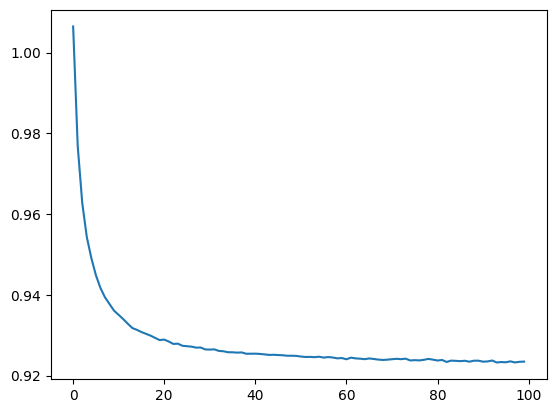

In [60]:
import matplotlib.pyplot as plt

plt.plot([v for i, v in train_process])

In [61]:
# test set 의 rmse 평가
test_data = ratings_test.copy()  # 원본 데이터 수정 방지
test_data['prediction'] = mf.predict(test_data)
test_data = test_data.dropna(subset=['prediction'])  # 유효한 예측만 사용
rmse = np.sqrt(np.mean((test_data['rating'] - test_data['prediction']) ** 2))

# 테스트 데이터셋에 대한 RMSE 계산
print(f"Test RMSE = {rmse:.4f}")

Test RMSE = 1.1905


### 특정 사용자에게 특정 영화 추천

In [67]:
ratings_test.head()

,user_id,movie_id,rating
3582,23,528,4
60498,695,242,5
53227,774,28,3
21333,417,550,3
3885,234,1035,3


In [66]:
mf.predict(ratings_test.head())

array([4.50486074, 2.76133082, 2.95696399, 2.62346506, 4.04646674])